<a href="https://colab.research.google.com/github/Tayyabaarif656/GD/blob/master/Copy_of_Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [3]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [4]:
ls

flickr8k.zip  kaggle.json


In [5]:
!kaggle datasets download -d shadabhussain/flickr8k

flickr8k.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
pwd


'/content/gdrive/My Drive/Kaggle'

In [8]:
# Location of Zip File
drive_path = '/content/gdrive/My Drive/Kaggle/flickr8k.zip'
local_path = '/content'

# Copy the zip file and move it up one level (AKA out of the drive folder)
!cp '{drive_path}' .

# Navigate to the copied file and unzip it quietly
os.chdir(local_path)
!unzip -q 'flickr8k.zip'

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from nltk.translate.bleu_score import sentence_bleu
import cv2
from google.colab.patches import cv2_imshow

In [11]:
# Loading Captions
caption_file_path='man_data_final.json'
with open(caption_file_path, 'r') as j:
    data = json.load(j)  

In [12]:
# Getting Captions and image names from json file
train_captions = []
img_name_vector = []
for i in range(0,700):
    for j in range(5):
        img_name_vector.append(data['images'][i]['filename'])
        train_captions.append('<start> '+str((data['images'][i]['sentences'][j]['raw']))+' <end>')

In [13]:
# Displaying some captions
train_captions[:10]

['<start> ایک شخص بینچ پر لیٹا ہے جبکہ اس کا کتا اس کے پاس بیٹھا ہے <end>',
 '<start> ایک شخص اس بینچ پر لیٹتا ہے جس پر ایک سفید کتا بھی بندھا ہوا ہے <end>',
 '<start> ایک آدمی باہر بینچ پر سو رہا ہے جس کے پاس ایک سفید اور سیاہ کتے تھے <end>',
 '<start> ایک قمیض کے بغیر شخص اپنے کتے کے ساتھ پارک بینچ پر پڑا ہے <end>',
 '<start> ایک آدمی بینچ پر زمین پر بیٹھے کتے کا پٹا پکڑے ہوے لیٹا ھوا ہے <end>',
 '<start> نارنگی رنگ کی ٹوپی پہنے ہوے ایک آدمی کسی کو گھورتے ہوے <end>',
 '<start> ایک شخص نارنگی رنگ کی ٹوپی اور عینک پہنے ہوے <end>',
 '<start> ایک عینک اور گیجس والا شخص تیز رنگ کی ٹوپی پہنے ہوے <end>',
 '<start> ایک عینک والے شخص نے بیئر کین سے بنی ٹوپی پہن رکھی ہے <end>',
 '<start> چھیدے ہوے کان والے آدمی نے عینک اور نارنگی رنگ کی ٹوپی پہنی ہوئی ہے <end>']

In [14]:
import pandas as pd
df = pd.DataFrame((img_name_vector,train_captions)).T
df.columns = ['Images','Captions']
df

,Images,Captions
0,1003163366_44323f5815.jpg,<start> ایک شخص بینچ پر لیٹا ہے جبکہ اس کا کتا...
1,1003163366_44323f5815.jpg,<start> ایک شخص اس بینچ پر لیٹتا ہے جس پر ایک ...
2,1003163366_44323f5815.jpg,<start> ایک آدمی باہر بینچ پر سو رہا ہے جس کے ...
3,1003163366_44323f5815.jpg,<start> ایک قمیض کے بغیر شخص اپنے کتے کے ساتھ ...
4,1003163366_44323f5815.jpg,<start> ایک آدمی بینچ پر زمین پر بیٹھے کتے کا ...
...,...,...
3495,3640443200_b8066f37f6.jpg,<start> ایک سوٹ میں ملبوس آدمی جس کو پھولوں وا...
3496,3640443200_b8066f37f6.jpg,<start> ایک سوٹ میں ملبوس آدمی جس کو پھولوں وا...
3497,3640443200_b8066f37f6.jpg,<start> ایک شخص چارباضابطہ لباس پہنے ہوئے لڑکی...
3498,3640443200_b8066f37f6.jpg,<start> چار دلہنیں دولہا کے ساتھ ڈرامائی طور پ...


In [15]:
# Loading ResNet-101-V2 model
# Removing fully connected layers
image_model = tf.keras.applications.ResNet101V2(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

171327488/171317808 [==============================] - 2s 0us/step


In [16]:
# loading and preprocessing images
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.resnet_v2.preprocess_input(img)
    return img, image_path

In [17]:
for file in os.walk('/content/Flickr_Data/Flickr_Data/'):
  print(file)

('/content/Flickr_Data/Flickr_Data/', ['Flickr_TextData', 'flickr8ktextfiles', 'Images'], [])
('/content/Flickr_Data/Flickr_Data/Flickr_TextData', [], ['ExpertAnnotations.txt', 'Flickr_8k.devImages.txt', 'Flickr_8k.testImages.txt', 'Flickr8k.lemma.token.txt', 'Flickr_8k.trainImages.txt', 'readme.txt', 'CrowdFlowerAnnotations.txt', 'Flickr8k.token.txt'])
('/content/Flickr_Data/Flickr_Data/flickr8ktextfiles', [], ['flickr_8k_val_dataset.txt', 'flickr_8k_train_dataset.txt'])
('/content/Flickr_Data/Flickr_Data/Images', [], ['535123126_c06c1ab9bf.jpg', '2732625904_4fbb653434.jpg', '1650280501_29810b46e5.jpg', '3397228832_8ce5b1c26f.jpg', '3107368071_724613fc4f.jpg', '2443380641_7b38d18f5b.jpg', '2171154778_8189169336.jpg', '3532205154_5674b628ea.jpg', '3259992164_94600858b3.jpg', '3587596696_9c5964c94d.jpg', '3041348852_872c027c16.jpg', '2776029171_5abdd5a22f.jpg', '2831723637_30d4456665.jpg', '1937104503_313d22a2d0.jpg', '2766765386_4c0beb939d.jpg', '425518464_a18b87c563.jpg', '2695962887_

In [18]:
# Compiling Dataset
encode_train = sorted(set(img_name_vector))
print(encode_train)
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
print(image_dataset)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

os.chdir('/content/Flickr_Data/Flickr_Data/Images/')

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())
 

['1003163366_44323f5815.jpg', '1007129816_e794419615.jpg', '1015118661_980735411b.jpg', '101669240_b2d3e7f17b.jpg', '1016887272_03199f49c4.jpg', '1022454428_b6b660a67b.jpg', '102351840_323e3de834.jpg', '102455176_5f8ead62d5.jpg', '1028205764_7e8df9a2ea.jpg', '103195344_5d2dc613a3.jpg', '1032460886_4a598ed535.jpg', '1042590306_95dea0916c.jpg', '1045521051_108ebc19be.jpg', '1057210460_09c6f4c6c1.jpg', '1067675215_7336a694d6.jpg', '1075867198_27ca2e7efe.jpg', '1077931201_1e0bb83105.jpg', '10815824_2997e03d76.jpg', '1082379191_ec1e53f996.jpg', '1088767354_2acee738cf.jpg', '109738763_90541ef30d.jpg', '109738916_236dc456ac.jpg', '109823395_6fb423a90f.jpg', '109823397_e35154645f.jpg', '110595925_f3395c8bd6.jpg', '111497985_38e9f88856.jpg', '111537217_082a4ba060.jpg', '111537222_07e56d5a30.jpg', '112178718_87270d9b4d.jpg', '1124448967_2221af8dc5.jpg', '1132772170_600610c5df.jpg', '1141718391_24164bf1b1.jpg', '1141739219_2c47195e4c.jpg', '1142283988_6b227c5231.jpg', '1143373711_2e90b7b799.jpg',

In [19]:
# Find the maximum length of caption in dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [20]:
# Choose the top k words from the vocabulary
top_k = 5000
# Tokeninzation
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
# Converting into to sequences
train_seqs = tokenizer.texts_to_sequences(train_captions)
print("Before: ",train_captions[0])
print("After: ",train_seqs[0])

Before:  <start> ایک شخص بینچ پر لیٹا ہے جبکہ اس کا کتا اس کے پاس بیٹھا ہے <end>
After:  [3, 2, 11, 141, 8, 261, 5, 61, 46, 24, 104, 46, 6, 54, 36, 5, 4]


In [21]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [22]:
# Padding each vector to the max_length of the captions
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [23]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [24]:
# Splitting data into training and validaiton
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [25]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(2800, 2800, 700, 700)

In [26]:
BATCH_SIZE = 10
BUFFER_SIZE = 10000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 2048
attention_features_shape = 100

In [27]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [28]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    # alignment score = tanh(X_E.W_E + H_D.W_D)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
    # attention weights = softmax(alignment scores)
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    # context vector = attention weights * extracted features
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [46]:
# Extract image features 
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [47]:
# Inputs extracted features 
# Pass these features and previous hidden layer to attention mechnism
# Attention mechanism returns context vector and attention weights
# after concatenating context vector with current input of decoder
# GRU then predict next wrod
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    
    context_vector, attention_weights = self.attention(features, hidden)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc2(x)

    return x, state, attention_weights
  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [48]:
# initializing encoder and decoder
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [49]:
# Setting Optimizer and Loss Function
optimizer = tf.keras.optimizers.Adadelta()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [50]:
checkpoint_path = "/content/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [51]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [52]:
# Training Function
@tf.function
def train_step(img_tensor, target):
  loss = 0
  # Initiating hidden state for first time
  hidden = decoder.reset_state(batch_size=target.shape[0])
  # current input to decoder
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      # Extracting features from encoder
      features = encoder(img_tensor)
      for i in range(1, target.shape[1]):
          # Passing features, previous hidden state and input to the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          # calculating loss
          loss += loss_function(target[:, i], predictions)
          dec_input = tf.expand_dims(target[:, i], 1)
  total_loss = (loss / int(target.shape[1]))
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))
  return loss, total_loss

In [53]:
EPOCHS = 30
loss_plot = []
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    # Getting current batch
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.9416
Epoch 1 Batch 100 Loss 2.9268
Epoch 1 Batch 200 Loss 2.8702
Epoch 1 Loss 2.991210
Time taken for 1 epoch 531.8083627223969 sec

Epoch 2 Batch 0 Loss 3.1477
Epoch 2 Batch 100 Loss 2.5581
Epoch 2 Batch 200 Loss 3.4530
Epoch 2 Loss 2.917457
Time taken for 1 epoch 461.41166615486145 sec

Epoch 3 Batch 0 Loss 3.1416
Epoch 3 Batch 100 Loss 3.0425
Epoch 3 Batch 200 Loss 2.5581
Epoch 3 Loss 2.779374
Time taken for 1 epoch 462.59273386001587 sec

Epoch 4 Batch 0 Loss 3.0839
Epoch 4 Batch 100 Loss 3.1185
Epoch 4 Batch 200 Loss 2.5871
Epoch 4 Loss 2.566882
Time taken for 1 epoch 466.204074382782 sec

Epoch 5 Batch 0 Loss 2.5401
Epoch 5 Batch 100 Loss 2.4628
Epoch 5 Batch 200 Loss 2.1866
Epoch 5 Loss 2.366758
Time taken for 1 epoch 461.3695366382599 sec

Epoch 6 Batch 0 Loss 2.3199
Epoch 6 Batch 100 Loss 2.5339
Epoch 6 Batch 200 Loss 1.9904
Epoch 6 Loss 2.260273
Time taken for 1 epoch 457.2058894634247 sec

Epoch 7 Batch 0 Loss 2.3029
Epoch 7 Batch 100 Loss 2.0106
Epoch

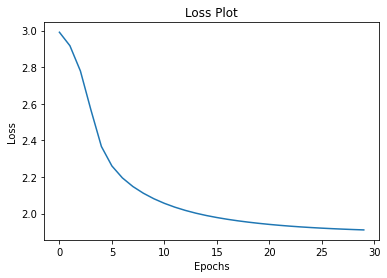

In [54]:
# Loss curve
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [55]:
# This function generate captions on evaluation data
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.reset_state(batch_size=1)
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot
        dec_input = tf.expand_dims([predicted_id], 0)
    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [56]:
# This function is used to plot attentions  
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Prediction Caption: کود ایک پر <end>
BLEU Score: 0.06806346850763627


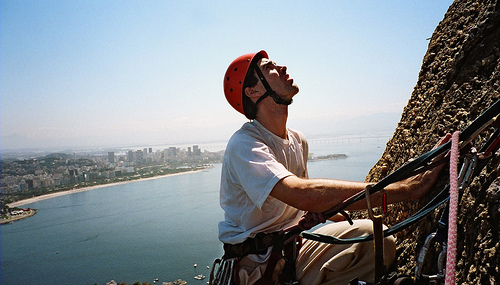

In [57]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
result, attention_plot = evaluate(image)
real = list(df[df['Images']==image]['Captions'])
cleaned = []
for i in range(len(real)):
    cleaned.append(real[i][7:-5])
predicted = ' '.join(result)
print ('Prediction Caption:', predicted)
bs = sentence_bleu(cleaned, predicted)
print('BLEU Score:',bs)
cv2_imshow(cv2.imread(image))

In [ ]:
score = 0
for i in range (0,len(img_name_val),5):
    image = img_name_val[i]
    result, attention_plot = evaluate(image)
    real = list(df[df['Images']==image]['Captions'])
    cleaned = []
    for i in range(len(real)):
        cleaned.append(real[i][7:-5])
    predicted = ' '.join(result)
    score += sentence_bleu(cleaned, predicted)
val_bleu = score/len(img_name_val)*5
print("BLEU score on validation data: ",val_bleu)

In [ ]:
image_url = 'https://www.snowboard-asylum.com/media/TSA%20Snowboard%20Guide/Snowboard%20Binding%20Buying%20Guide/SS20/Board-Med-Flex.jpg'
image_extension = image_url[-18:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
Image.open(image_path)